In [8]:
import os
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import MobileNetV2


In [9]:
BASE_DIR = 'dataset' 
train_dir = os.path.join(BASE_DIR, 'train')
valid_dir = os.path.join(BASE_DIR, 'validation')
test_dir = os.path.join(BASE_DIR, 'test')

## EDA

Data Train:
Jumlah gambar kelas CORROSION: 693
Jumlah gambar kelas NOCORROSION: 580

Data Validation:
Jumlah gambar kelas CORROSION: 198
Jumlah gambar kelas NOCORROSION: 166

Data Test:
Jumlah gambar kelas CORROSION: 99
Jumlah gambar kelas NOCORROSION: 83


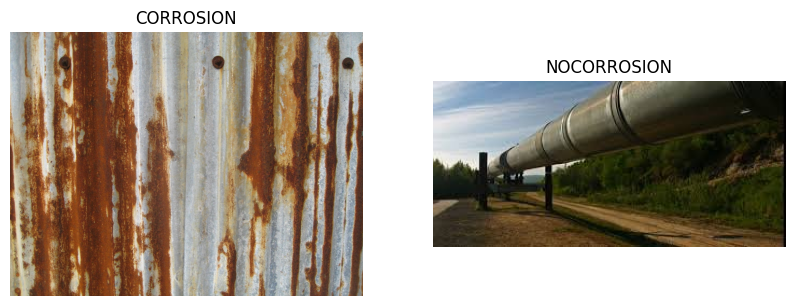

In [10]:
def count_images(directory):
    class_names = os.listdir(directory)
    for cls in class_names:
        path = os.path.join(directory, cls)
        print(f"Jumlah gambar kelas {cls}: {len(os.listdir(path))}")

print("Data Train:")
count_images(train_dir)
print("\nData Validation:")
count_images(valid_dir)
print("\nData Test:")
count_images(test_dir)

# Visualisasi beberapa contoh gambar
plt.figure(figsize=(10,5))
for i, cls in enumerate(os.listdir(train_dir)):
    plt.subplot(1,2,i+1)
    sample_img_path = os.path.join(train_dir, cls, os.listdir(os.path.join(train_dir, cls))[0])
    img = plt.imread(sample_img_path)
    plt.imshow(img)
    plt.title(cls)
    plt.axis('off')
plt.show()


## PRE PROCESS

In [11]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

valid_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)


Found 1273 images belonging to 2 classes.
Found 364 images belonging to 2 classes.
Found 182 images belonging to 2 classes.


In [12]:
def build_mobilenetv2_model(input_shape=(224,224,3)):
    base_model = MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')
    base_model.trainable = False  # Freeze semua layer pretrained

    inputs = Input(shape=input_shape)
    x = base_model(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation='relu')(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)

    model = models.Model(inputs, outputs)
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

model = build_mobilenetv2_model()
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [13]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)

history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=50,
    callbacks=[early_stop]
)


d:\Miniconda\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 67s 2s/step - accuracy: 0.7197 - loss: 0.5146 - val_accuracy: 0.8764 - val_loss: 0.3007
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.9359 - loss: 0.1696 - val_accuracy: 0.8984 - val_loss: 0.2746
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.9567 - loss: 0.1152 - val_accuracy: 0.8709 - val_loss: 0.3857
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.9552 - loss: 0.1158 - val_accuracy: 0.8984 - val_loss: 0.2955
Epoch 5/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.9767 - loss: 0.0760 - val_accuracy: 0.8956 - val_loss: 0.3231
Epoch 6/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.9644 - loss: 0.0822 - val_accuracy: 0.8956 - val_loss: 0.2735
Epoch 7/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 38s 952ms/step - accuracy: 0.9832 - loss: 0.0585 - val_accuracy: 0.8984 - val_loss: 0.2887
Epoch 8/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 37s 940ms/step - accuracy: 0.9841 - loss: 0.0507 - val_accuracy: 0.9093 - val

In [14]:
model.save('model_mobilenetv2_corrosion.keras')

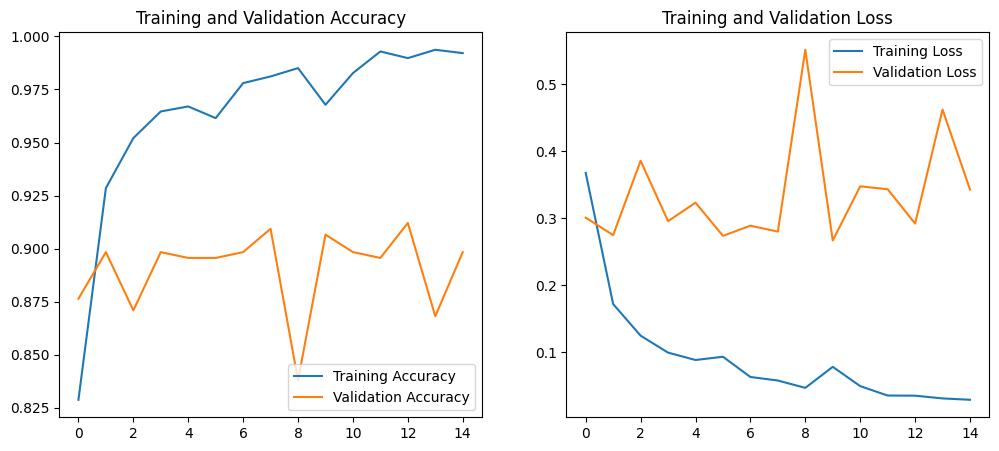

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()


6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 744ms/step
Classification Report:
              precision    recall  f1-score   support

   CORROSION       0.89      0.94      0.92        99
 NOCORROSION       0.92      0.87      0.89        83

    accuracy                           0.91       182
   macro avg       0.91      0.90      0.91       182
weighted avg       0.91      0.91      0.91       182



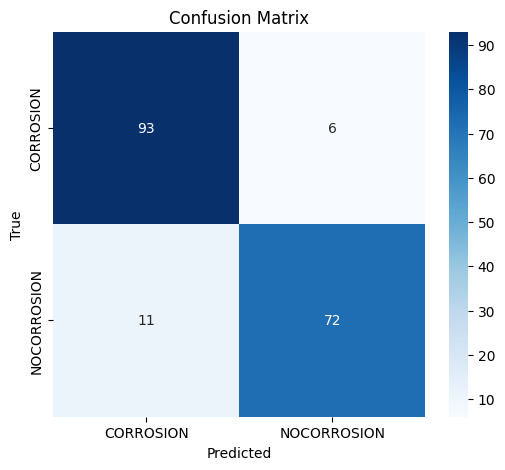

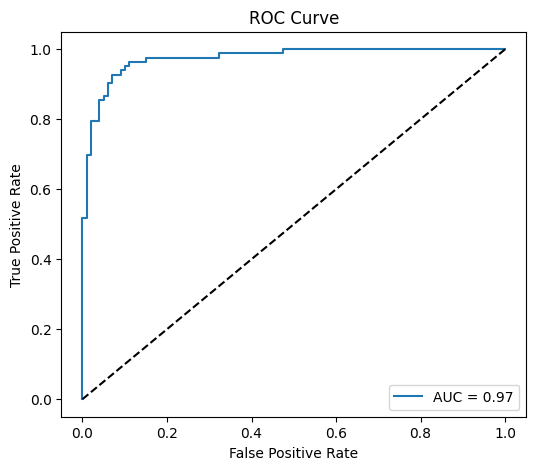

In [16]:


y_prob = model.predict(test_generator).flatten()
y_pred = (y_prob >= 0.5).astype(int)
y_true = test_generator.classes

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=test_generator.class_indices.keys(),
            yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

fpr, tpr, thresholds = roc_curve(y_true, y_prob)
auc = roc_auc_score(y_true, y_prob)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()
